In [42]:
from nearline_helpers import *
%jsroot on

In [43]:
infile = '../bin/run302/run00302_00000.mid.root'
f = r.TFile(infile)
t = f.Get("tree")
# t.Print()

In [44]:
print([x.GetName() for x in t.GetListOfBranches()])

['waveforms_raw', 'waveforms_corr', 'lyso_waveforms', 'nai_waveforms', 't0_waveforms', 'hodo_x_waveforms', 'hodo_y_waveforms', 'lyso_integrals', 'nai_integrals', 't0_integrals', 'hodo_x_integrals', 'hodo_y_integrals', 'pileup_tag', 'clusters', 'hodoscope']


---

In [45]:
t.GetEntry(0)
peaks = t.pileup_tag[0]
peaks

In [46]:
peaks.Show()


PileupTagger:
    crateNum: 0
    amcSlot: 1
    channelTag: 2
    eventNum: 0



In [47]:
c = r.TCanvas()
t.Draw("pileup_tag.peak_times:pileup_tag.npeaks","","colz")
c.SetLogz()
c.Draw()

In [53]:
c = r.TCanvas()
t.Draw("lyso_integrals.integral:pileup_tag.npeaks","","colz")
c.SetLogz()
c.Draw()

In [54]:
c = r.TCanvas()
t.Draw("lyso_integrals.integral:pileup_tag.npeaks","@lyso_integrals.size() == 1","colz")
c.SetLogz()
c.Draw()

In [48]:
c = r.TCanvas()
t.Draw("pileup_tag.npeaks","","colz")
c.SetLogz()
c.Draw()

In [49]:
def plot_peak_finding(peak, ax=None, **kwargs):
    inti = peak.integral.GetObject()
    # trace = inti.raw.GetObject().trace
    plot_integral(inti, ax=ax, subtract_pedestal=True,**kwargs)
    for i in range(peak.npeaks):
        ti,ampi = peak.peak_times[i], peak.peak_amplitudes[i]
        plt.plot(ti, ampi, 'k*',label=f'time={ti:.2f}\namplitude={ampi:.2f}')
    plt.legend()
# plot_peak_finding(peaks)
# plt.show()

260.0


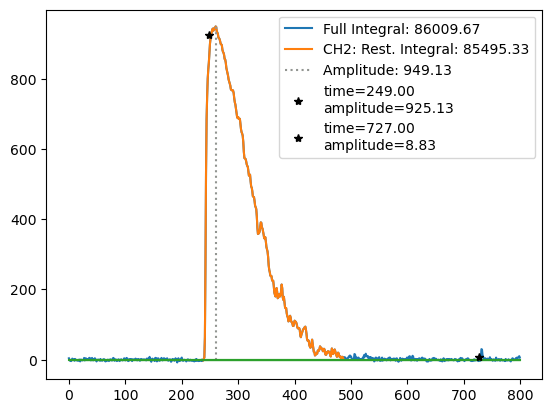

230.0


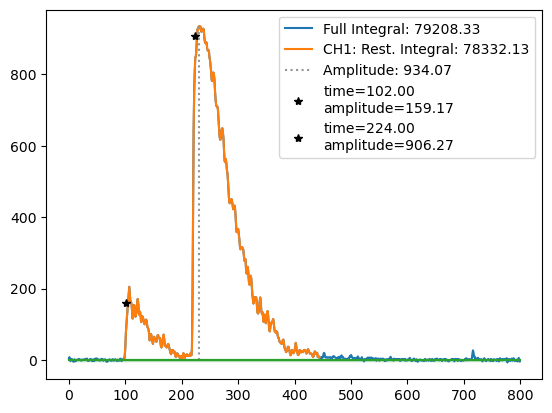

229.0


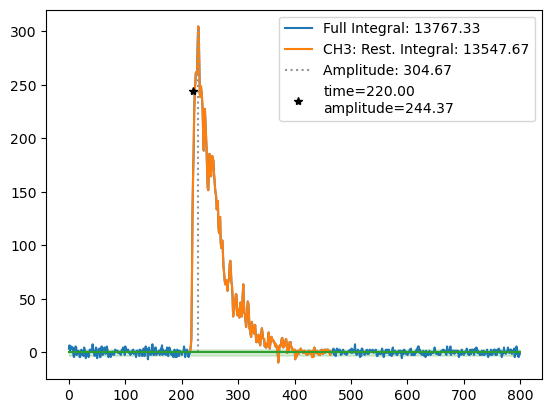

250.0


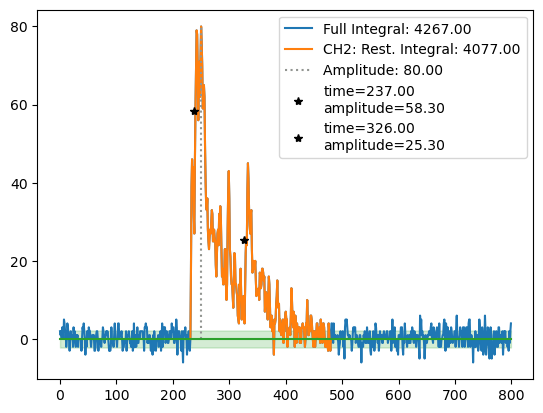

243.0


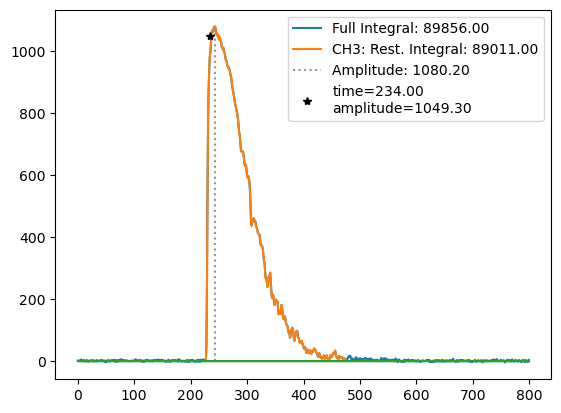

249.0


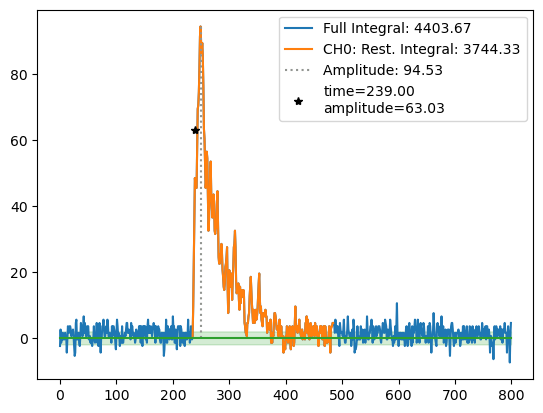

252.0


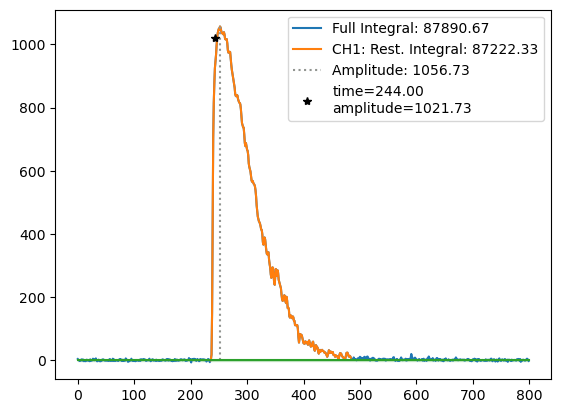

243.0


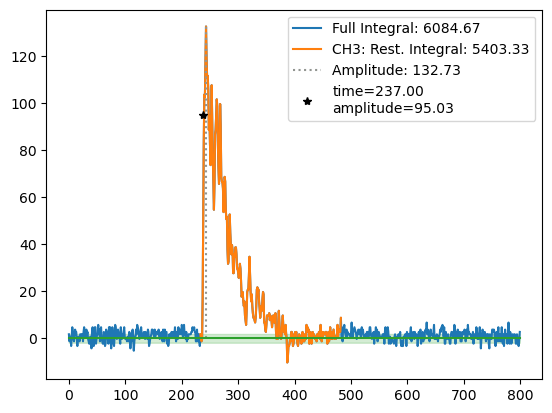

253.0


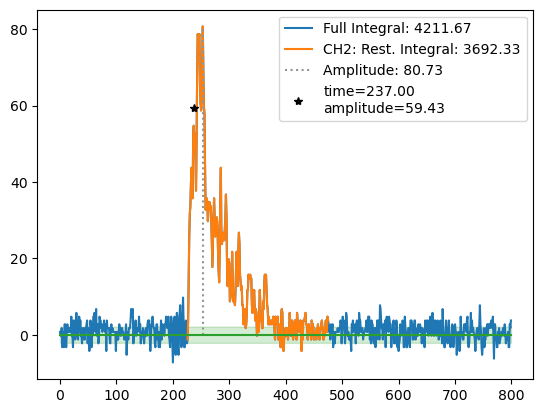

254.0


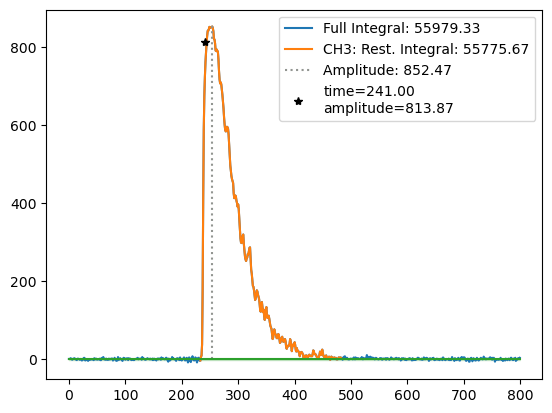

In [50]:
for i, e in enumerate(t):
    if( i > 4):
        break 
    for j,wf in enumerate(e.pileup_tag):
        plot_peak_finding(wf)
        print(wf.integral.GetObject().peak_time)
        # plt.xlim(200,300)
        plt.show()
    #     break
    # break

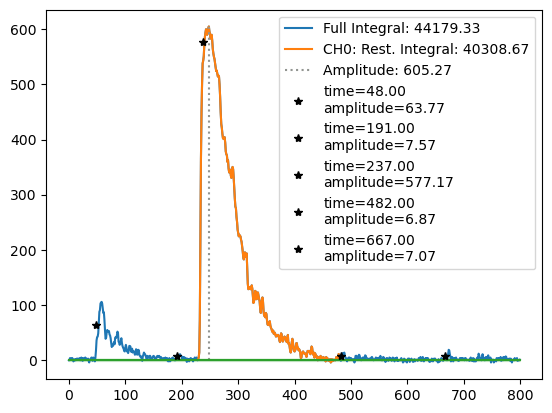

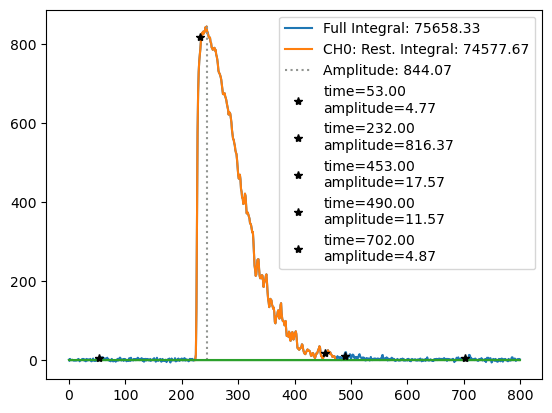

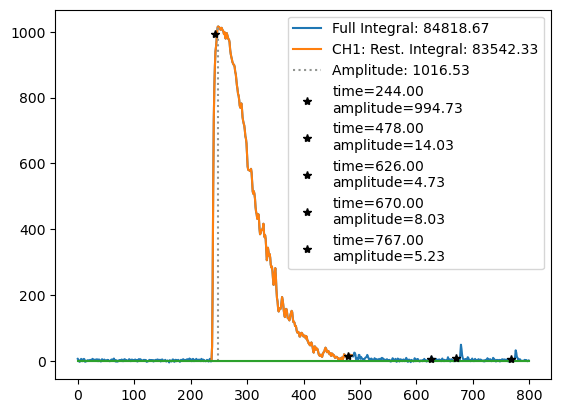

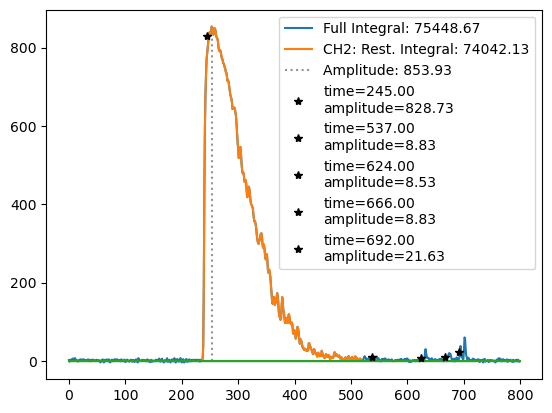

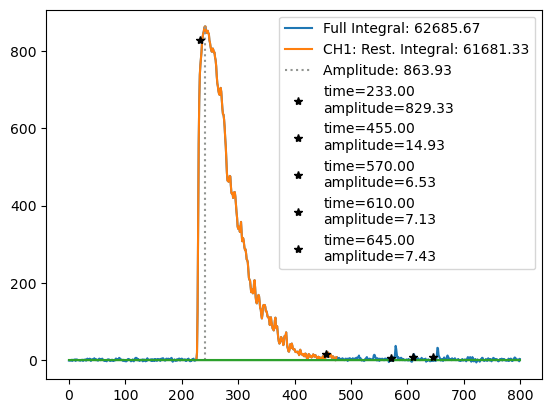

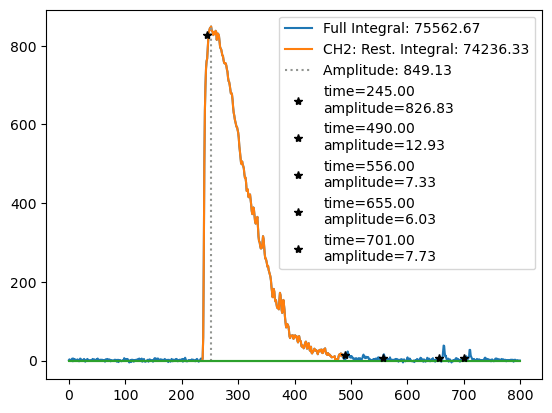

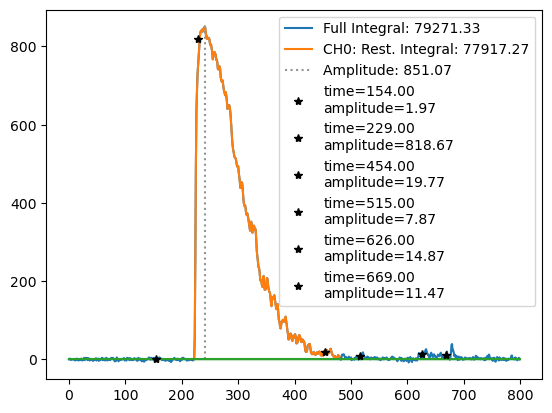

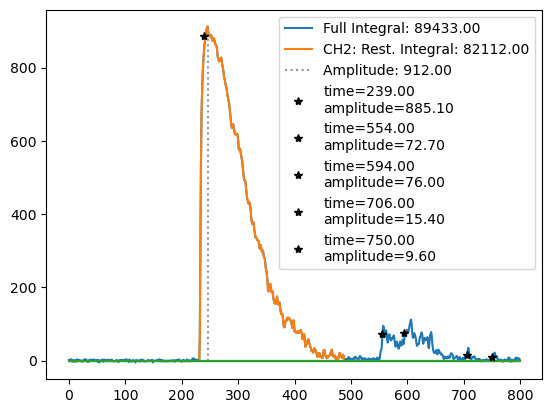

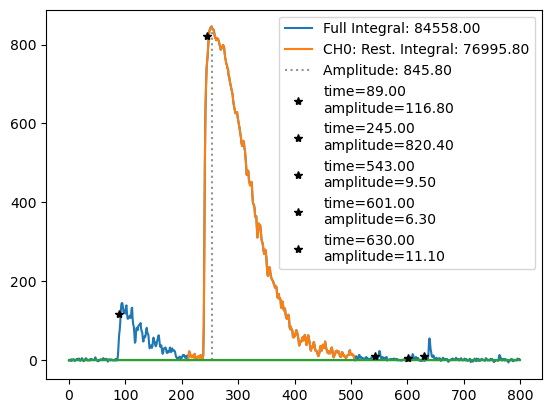

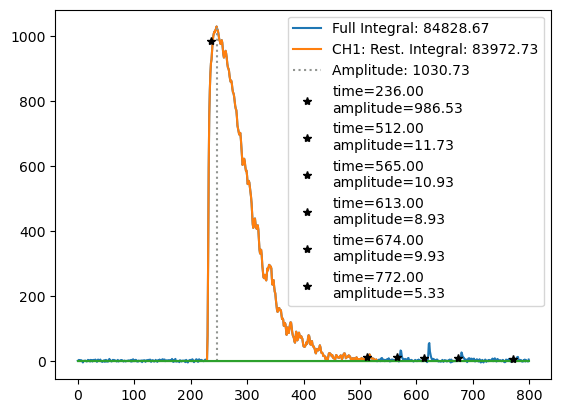

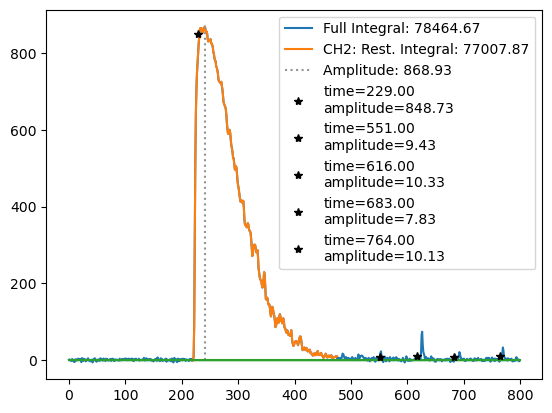

In [51]:
counter = 0
for i, e in enumerate(t):
    for peak in e.pileup_tag:
        if peak.npeaks > 4:
            counter += 1
            plot_peak_finding(peak)
            # plt.ylim(-1,100)
            plt.show()
    if(counter > 10):
        break

/home/jlab/github/test-beam-2023-unpacker/plotting/nearline_helpers.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


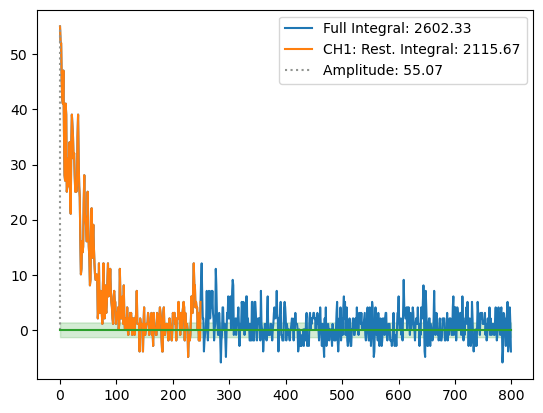

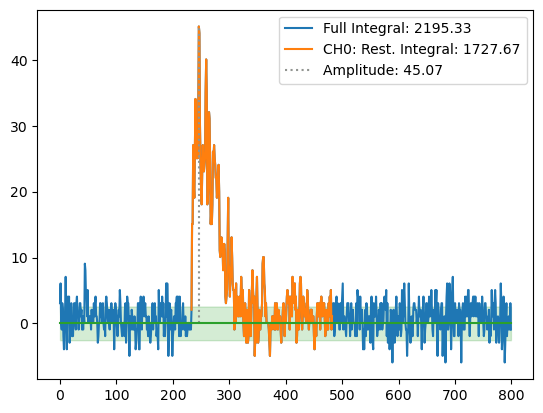

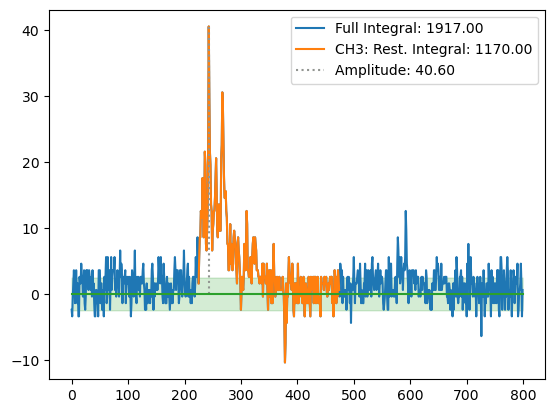

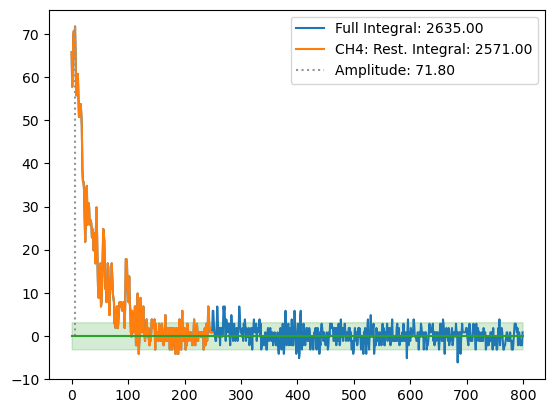

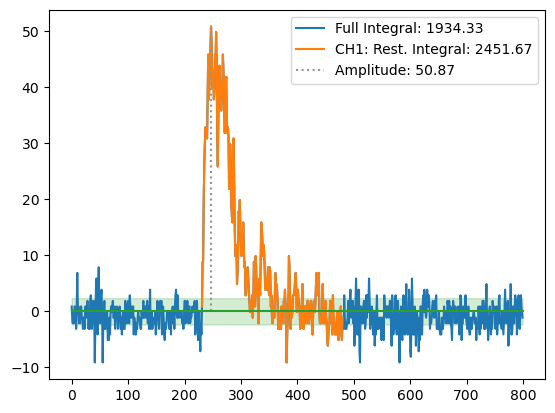

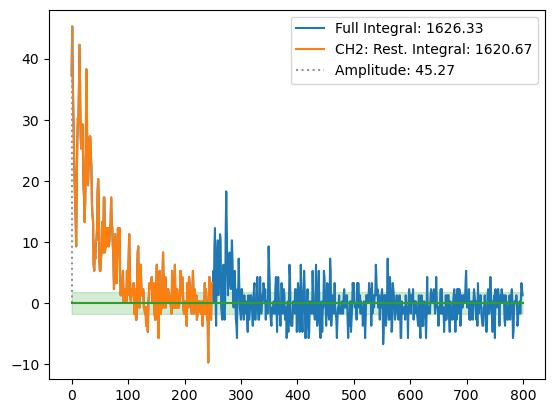

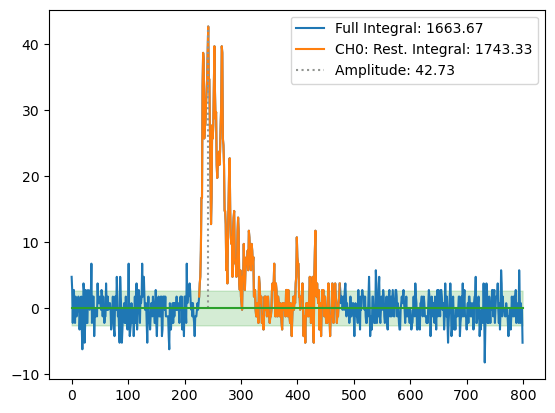

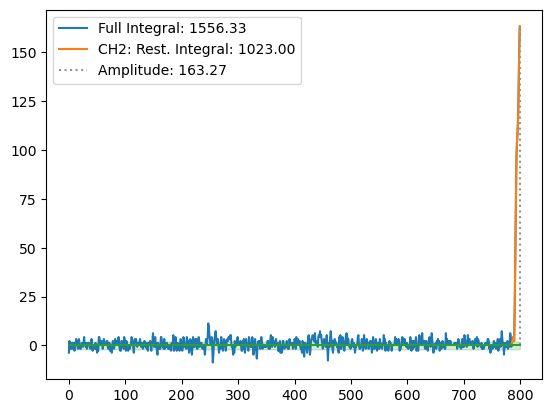

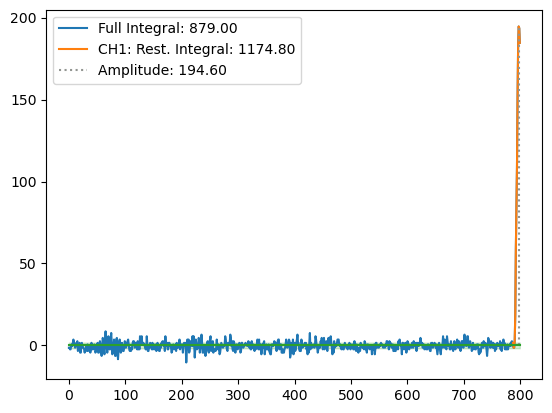

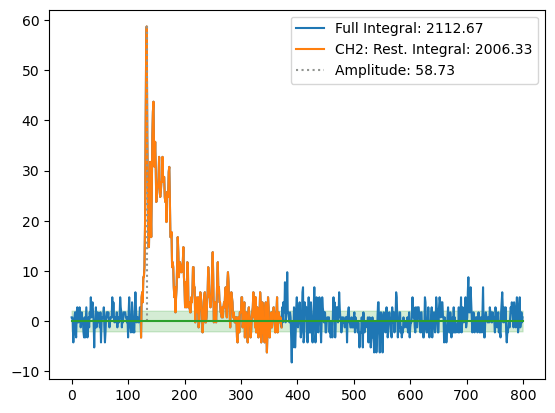

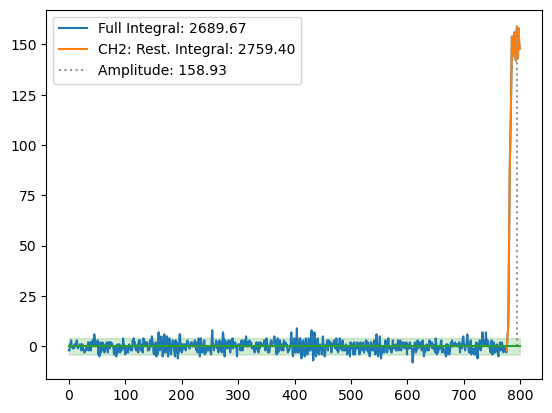

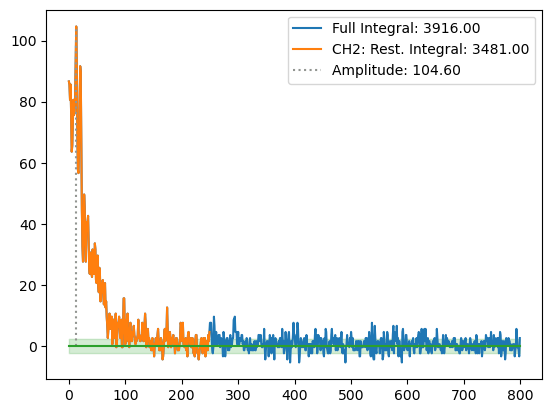

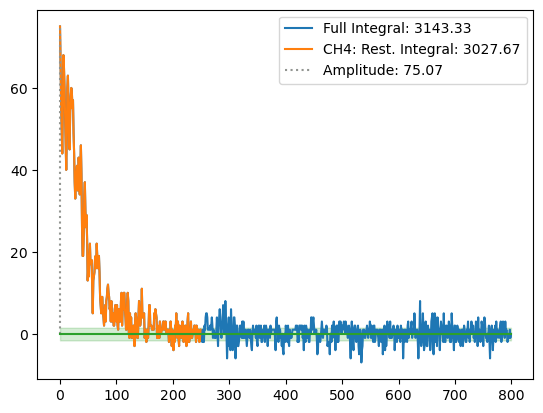

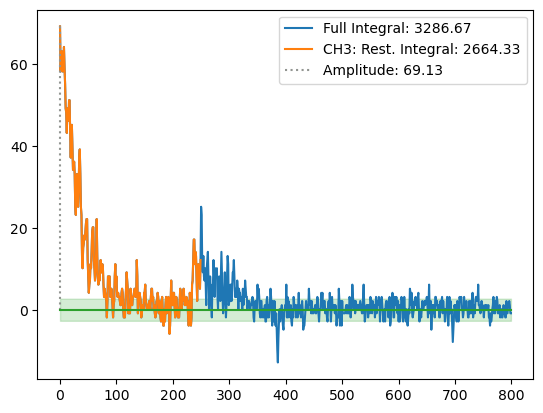

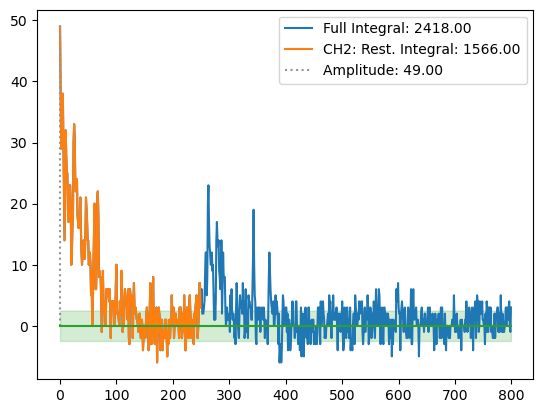

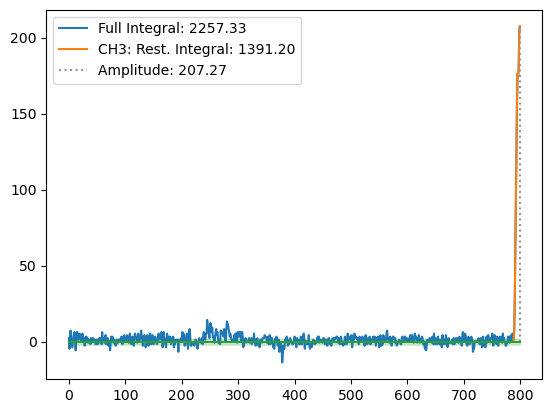

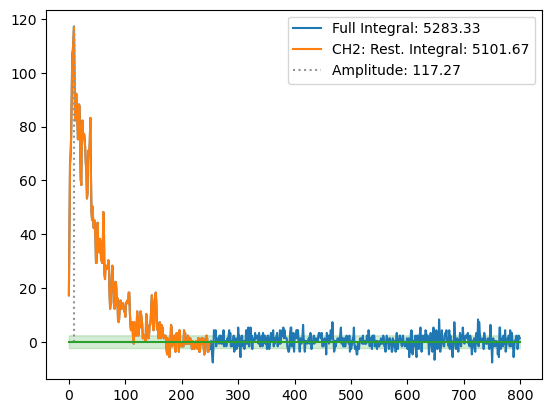

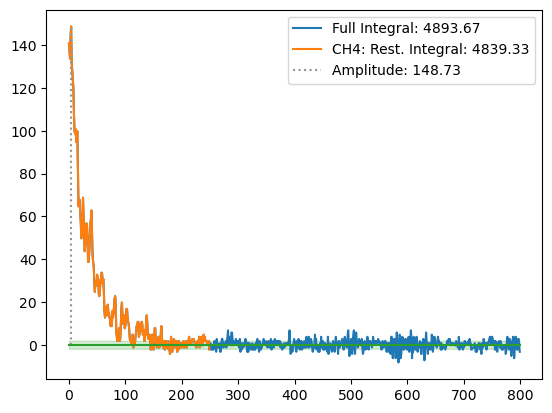

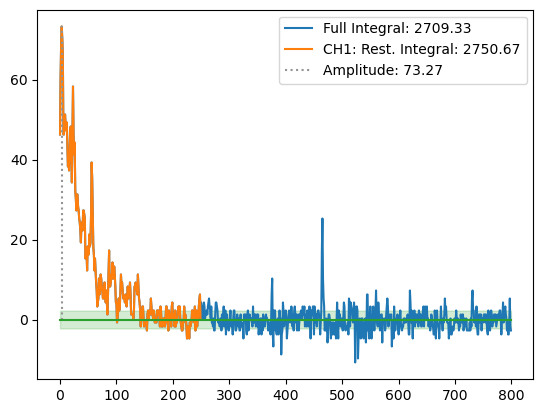

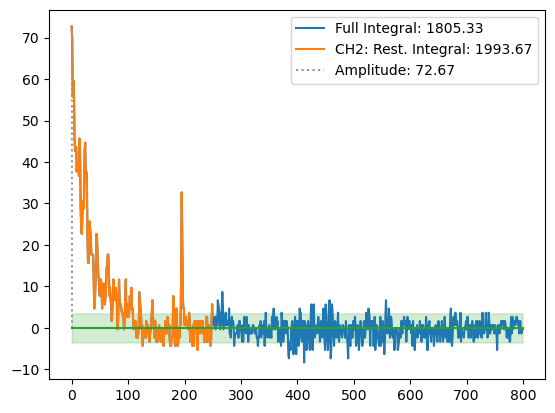

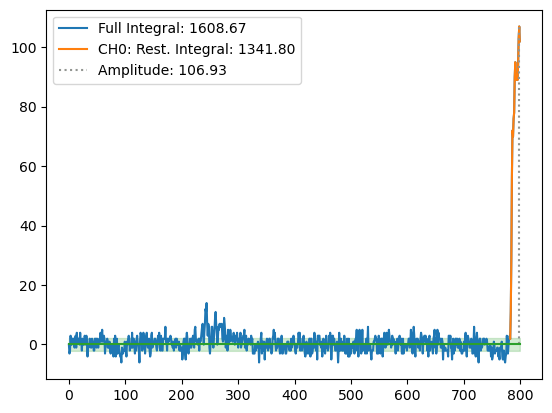

In [52]:
counter = 0
for i, e in enumerate(t):
    for peak in e.pileup_tag:
        if peak.npeaks < 1:
            counter += 1
            plot_peak_finding(peak)
    if(counter > 20):
        break

In [ ]:
c = r.TCanvas()
t.Draw("lyso_integrals.integral","", "colz")
c.Draw()

In [ ]:
c = r.TCanvas()
t.Draw("lyso_integrals.integral","pileup_tag.npeaks == 0 && lyso_integrals.integration_window.first > 100", "colz")
c.Draw()

---

In [ ]:
t.GetEntry(0)
wf = t.lyso_waveforms[0]
plot_waveform(wf)

In [ ]:
plot_waveform(wf)
plt.xlim(300,400)
plt.show()

In [ ]:
def lognormal_distribution(x,p):
    A = p[0]
    x0 = p[1]
    mu = p[2]
    sigma = p[3]
    C = p[4]
    func =  A * 1/(x-x0) * np.exp(- np.power(np.log(x-x0) - mu,2)/(2*sigma*sigma)) + C
    return np.where(x > x0, func, C)

from g2fit.fitting import PyFit
guess = [1000, 300, 2, 1, 0]
trace = np.array(wf.trace,dtype=float) - wf.pedestalLevel
samples = np.array([i for i in range(len(trace))])
fiti = PyFit(samples, trace, lognormal_distribution, guess, np.full_like(samples, wf.pedestalStdev), 
            #  limits=(300,700)
             limits=(0,300)
    )
fiti.fit()
fiti.simple_plot()
plt.plot(samples,trace)
plt.plot(samples, fiti.eval(samples), 'r:')
# plt.plot(samples, lognormal_distribution(samples,guess))
plt.show()

In [ ]:
def peak_search(wf):
    # tweaked implementation of alg 3 from here incorporating a rolling average
    # https://www.sciencedirect.com/science/article/pii/S0010465510004182#fg0010
    pedestal = wf.pedestalLevel
    stdev = wf.pedestalStdev
    relative_prominance = 4*stdev 
    trace = np.array(wf.trace, dtype=float)
    samples = np.array([i for i in range(len(trace))])
    trace -= pedestal

    window_length = 15
    running = np.convolve(trace, np.ones(window_length), "valid")/window_length
    plt.plot(samples, trace)
    plt.plot(samples[:-(window_length-1)], running)
    front_time = 15
    back_time = 15
    dead_time = 25
    peaks = []
    for i in range(front_time, len(running)-back_time):
        w1 = running[i-front_time]
        w2 = running[i]
        w3 = running[i+back_time]
        if(w2-w1 > relative_prominance and w2-w3 > relative_prominance and (len(peaks) == 0 or i > peaks[-1] + dead_time)):
            peaks.append(i)
            plt.plot([i], [running[i]], 'k*',label=f'Peak {i} -> {running[i]:.0f}', markersize=10)
            plt.plot([i,]*2, [0, running[i]], 'k:')
            plt.plot([i-front_time,]*2,[w1,w1+relative_prominance], 'C4X--')
            plt.plot([i+front_time,]*2,[w3,w3+relative_prominance], 'C4X--')

    # for ti in wf.trace:
    plt.plot(samples, np.full_like(samples,0))
    plt.plot(samples, np.full_like(samples,0+relative_prominance))
t.GetEntry(2)
for wf in t.lyso_waveforms:
    peak_search(wf)
    plt.legend(title=f'{wf.pedestalLevel=:.2f}\n{wf.pedestalStdev=:.2f}\n')
    plt.show()

In [ ]:
for i, e in enumerate(t):
    if( i > 10):
        break 
    for j,wf in enumerate(e.lyso_waveforms):
        peak_search(wf)
        plt.title(f'Waveform: {i},{j}')
        plt.legend()
        plt.show()

In [ ]:
t.GetEntry(5)
wf = t.lyso_waveforms[1]
plot_waveform(wf)
plt.show()

In [ ]:
spec = r.TSpectrum(20)

In [ ]:
import cppyy

dest = r.Double()

In [ ]:
nfound = spec.Search1HighRes(wf.trace, dest, wf.trace.size(), 2,10,True)